# User Guide

In [1]:
from hydrodata import Station, utils
import hydrodata.datasets as hds
from hydrodata import plot
from hydrodata import services
from arcgis2geojson import arcgis2geojson
import matplotlib.pyplot as plt
import geopandas as gpd
import warnings

In [2]:
warnings.filterwarnings("ignore")

## Datasets

To get started, we get the information for a USGS station using `Station` class. First, lets explore the available USGS stations and select one. `interactive_map` function from `utils` can be used to find all the stations within a bounding box.

In [3]:
utils.interactive_map([-70, 44, -69, 46])

In [4]:
wshed = Station('2000-01-01', '2010-01-21', station_id='01031500')

### NHDPlus

Then, using the watershed geometry we can use the `datasets` module to access other databases. Lets start by the main upstream river channel, the tributatires upstream, catchments for each river segment, and all USGS stations up to 150 km upstream of the main river channel using `NLDI` class.

In [5]:
nldi = hds.NLDI
tributaries = nldi.tributaries(wshed.station_id)
main_channel = nldi.main(wshed.station_id)
catchments = nldi.catchments(wshed.station_id)
stations = nldi.stations(wshed.station_id, navigation="upstreamMain", distance=150)

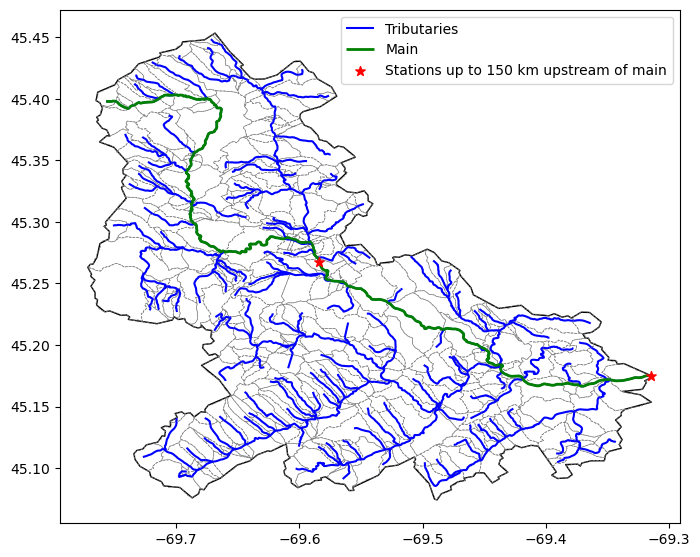

In [6]:
ax = wshed.basin.plot(facecolor='none', edgecolor='k', figsize = (8, 8))
catchments.plot(ax=ax, facecolor='none', edgecolor='grey', ls= "--", lw=0.5, zorder=1)
tributaries.plot(ax=ax, color='b', label='Tributaries', zorder=2)
main_channel.plot(ax=ax, color='g', lw=2, label='Main', zorder=3)
stations.plot(ax=ax, color='r', label='Stations up to 150 km upstream of main', marker='*', zorder=4, markersize=50)
ax.figure.set_dpi(100)
ax.legend(loc='best');

### NWIS

The daily mean streamflow data can be retrieved from NWIS service.

In [7]:
qobs = hds.nwis_streamflow(wshed.station_id, wshed.start, wshed.end)

### Daymet

The climate data at the location of the station can be retrieved from Daymet. Additionally, we can get Potential EvapoTranspiration based on the Daymetdata using the `pet` flag. Data can be downloaded for both a single pixel and gridded.

In [8]:
variables = ["tmin", "tmax", "prcp"]
clm_p = hds.daymet_byloc(wshed.lon, wshed.lat, start=wshed.start, end=wshed.end, variables=variables, pet=True)
clm_g = hds.daymet_bygeom(wshed.geometry, start='2005-01-01', end='2005-01-31', variables=variables, pet=True)

### SSEBop

The daily actual evapotranspiration can be retrieved from SEEBop database. Note that since this service does not offer a web service and data are available as raster files on the server, this function is not as fast as other functions and download speed might be the bottleneck. Data can be downloaded for both a single pixel and gridded.

In [9]:
eta_p = hds.ssebopeta_byloc(*wshed.coords, start='2005-01-01', end='2005-01-10')
eta_g = hds.ssebopeta_bygeom(wshed.geometry, start='2005-01-01', end='2005-01-10')

### DEM

DEM can be retrieved for the station's contributing watershed at 1 arc-second (30 m) resolution, as follows:

In [10]:
dem = hds.nationalmap_dem(wshed.geometry, resolution=1)

### NLCD

Land cover, imperviousness, and canopy data are retrieved from NLCD.

In [11]:
lulc = hds.nlcd(wshed.geometry, years={'impervious': 2016, 'cover': 2016, 'canopy': 2016}, resolution=1)

### Adding New Databases

Three tools are provided in `services` module for adding databases that are not available in hydrodata; `ArcGISREST` for adding ArcGIS RESTful-based services, `wms_bygeom` for WMS-based services, and `wfs_bygeom` for WFS-based services. For example, lets use ``services`` module for accessing [Los Angeles GeoHub](http://geohub.lacity.org/) RESTful service, NationalMap's [3D Eleveation Program](https://www.usgs.gov/core-science-systems/ngp/3dep) via WMS and [FEMA National Flood Hazard Layer](https://www.fema.gov/national-flood-hazard-layer-nfhl) via WFS for a watershed in Los Angeles:

In [12]:
la_wshed = Station('2005-01-01', '2005-01-31', '11092450')

url_rest = "https://maps.lacity.org/lahub/rest/services/Stormwater_Information/MapServer/10"
s = services.ArcGISREST(url_rest, outFormat="json")
s.get_featureids(la_wshed.geometry)
storm_pipes = s.get_features()

url_wms = "https://elevation.nationalmap.gov/arcgis/services/3DEPElevation/ImageServer/WMSServer"
slope = services.wms_bygeom(
                  url_wms,
                  "3DEP",
                  geometry=wshed.geometry,
                  version="1.3.0",
                  layers={"slope": "3DEPElevation:Slope Degrees"},
                  outFormat="image/tiff",
                  resolution=1)

url_wfs = "https://hazards.fema.gov/gis/nfhl/services/public/NFHL/MapServer/WFSServer"
r = services.wfs_bybox(
                   url_wfs,
                   bbox=la_wshed.geometry.bounds,
                   version="2.0.0",
                   layer="public_NFHL:Base_Flood_Elevations",
                   outFormat="esrigeojson",
                   in_crs="epsg:4326",
                   out_crs="epsg:4269")
flood = gpd.GeoDataFrame.from_features(arcgis2geojson(r.json()),
                                       crs="epsg:4269").to_crs("epsg:4326")

## Plotting

All the gridded data are returned as [xarray](https://xarray.pydata.org/en/stable/) datasets and data arrays that has efficient data processing tools. Note that Daymet dataset's projection is [Lambert](https://daymet.ornl.gov/overview). For the land cover data, a helper function exists called `cover_legends` that provide the official colors and legends for plotting.

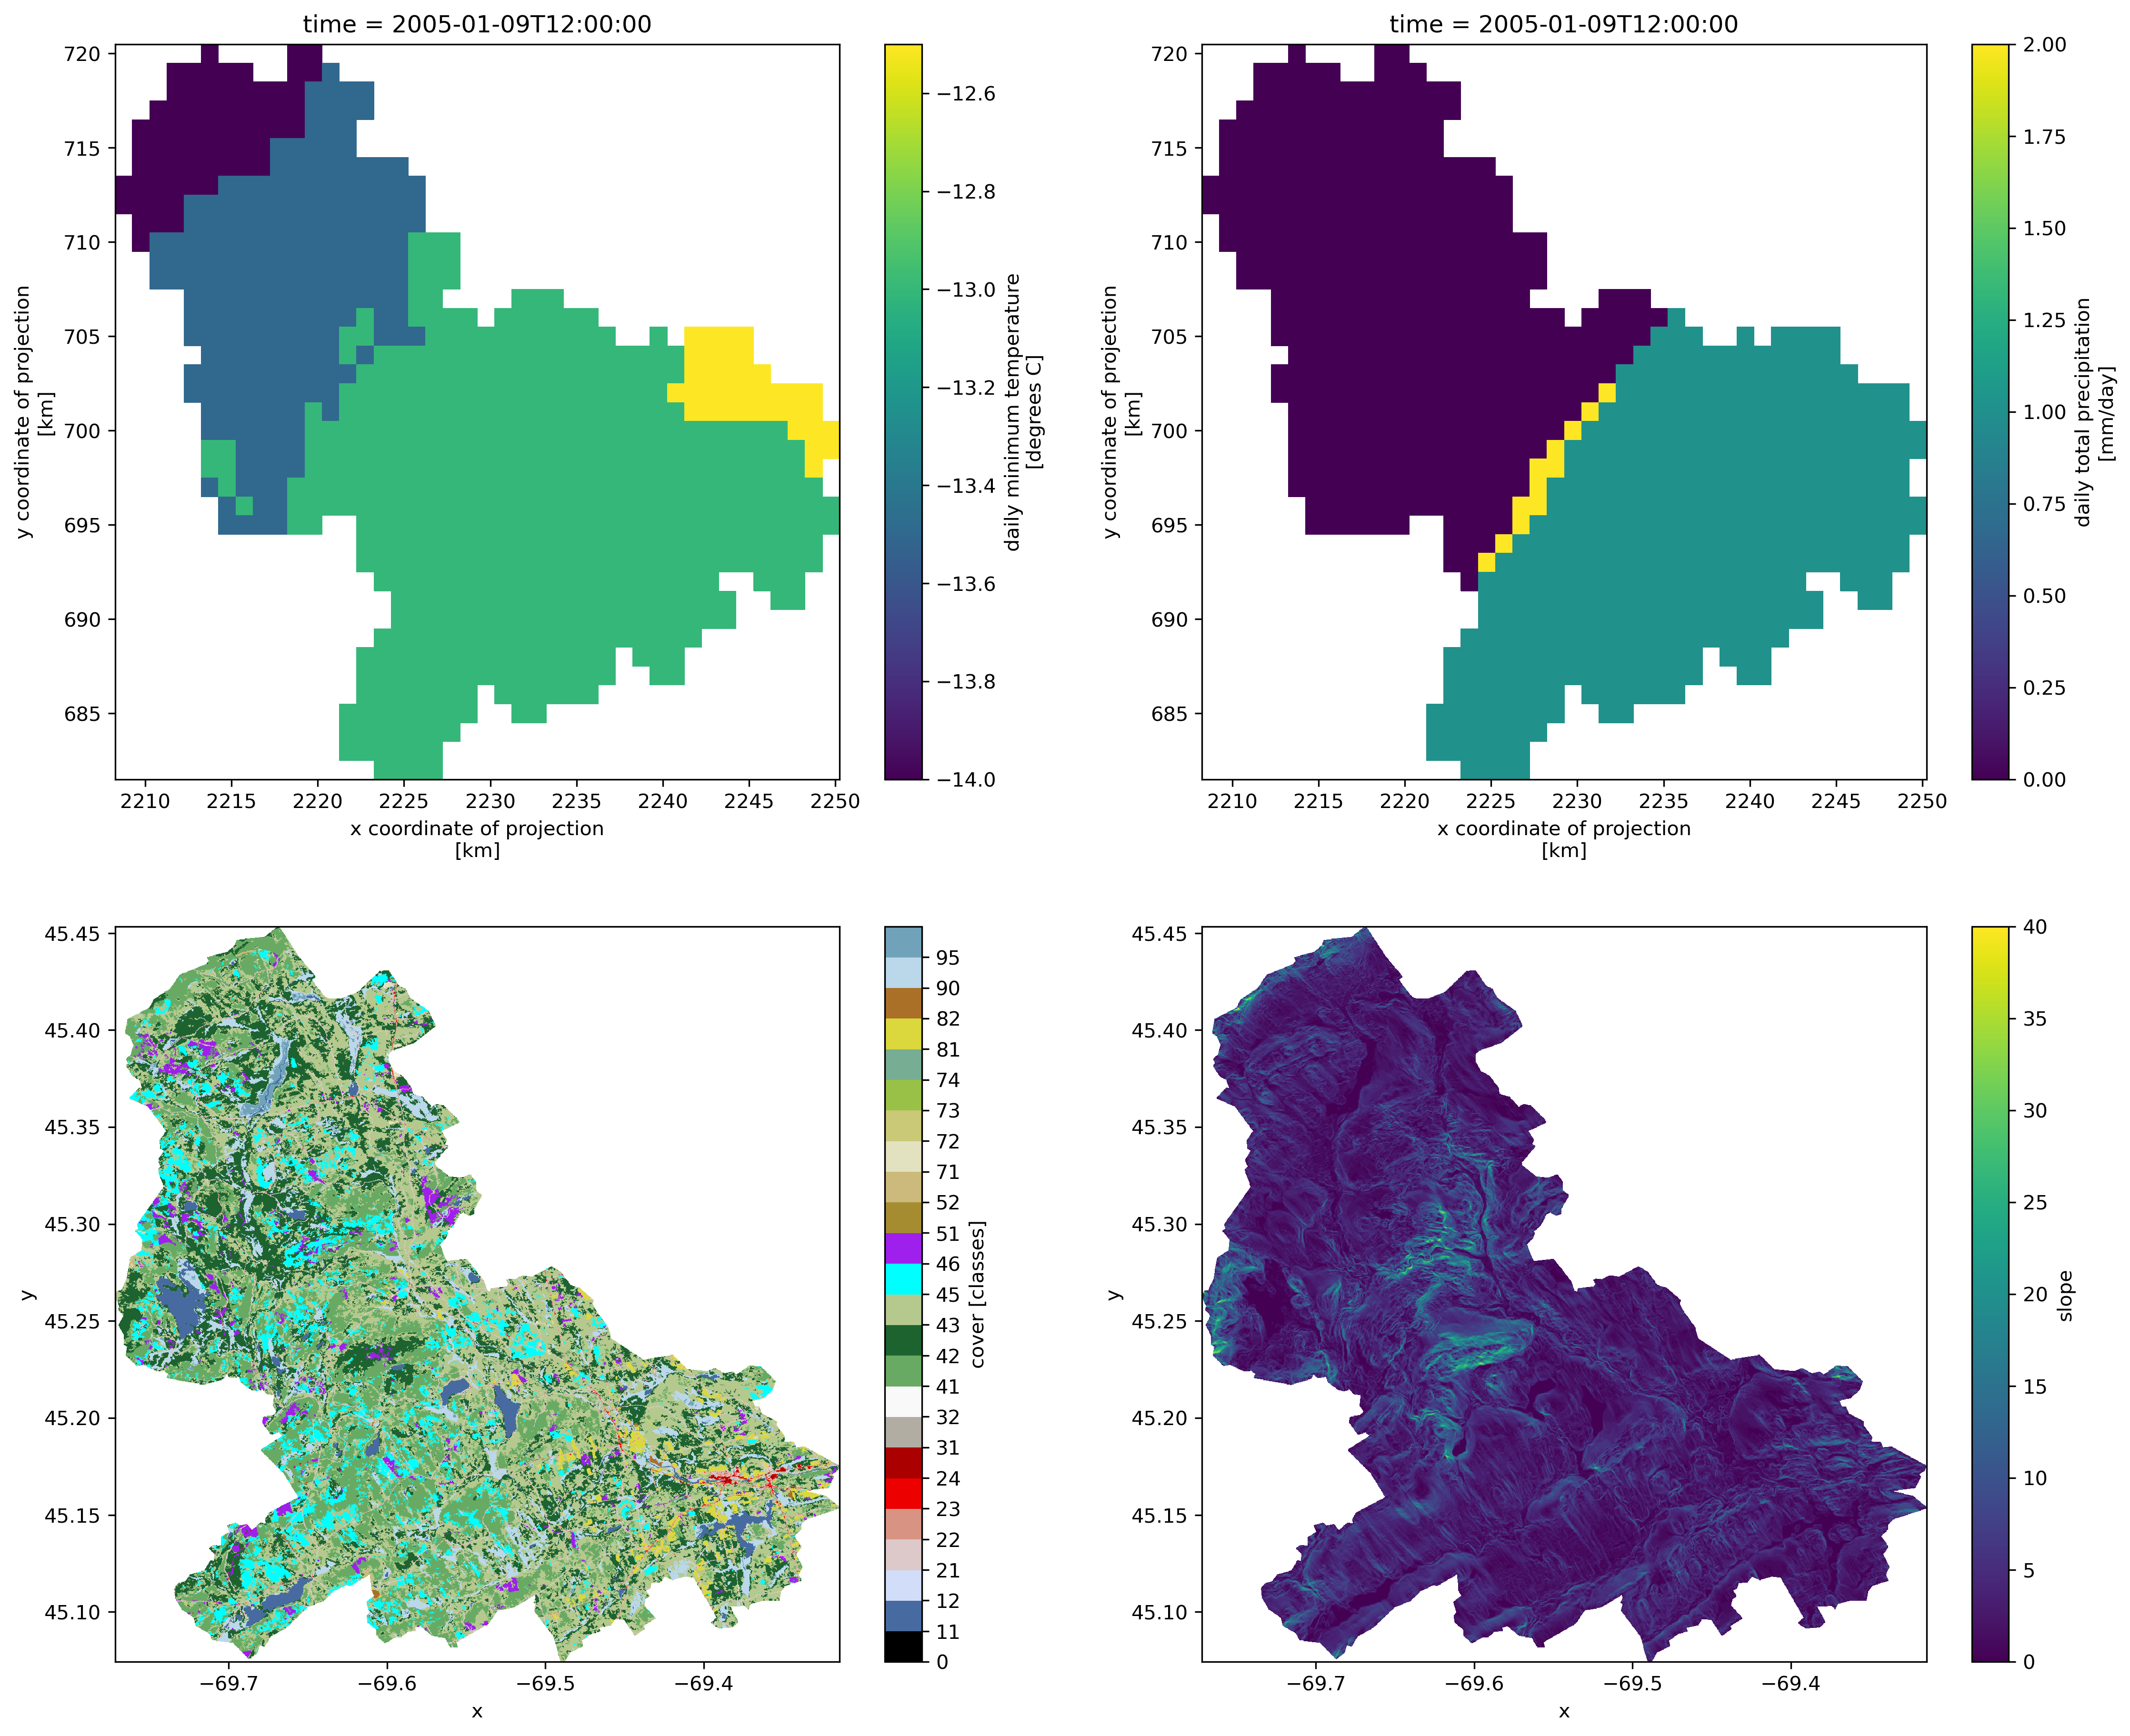

In [13]:
cmap, norm, levels = plot.cover_legends()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 15))
clm_g.tmin.isel(time=8).plot(ax=axes[0, 0])
clm_g.prcp.isel(time=8).plot(ax=axes[0, 1])
lulc.cover.where(lulc.cover > 0, drop=True).plot(ax=axes[1, 0], cmap=cmap, levels=levels, cbar_kwargs={"ticks": levels[:-1]})
slope.where(slope < 255, drop=True).plot(ax=axes[1, 1])
fig.set_dpi(300);

Moreover, `signatures` function in `plot` module, plots the hydrologic signatures graphs.

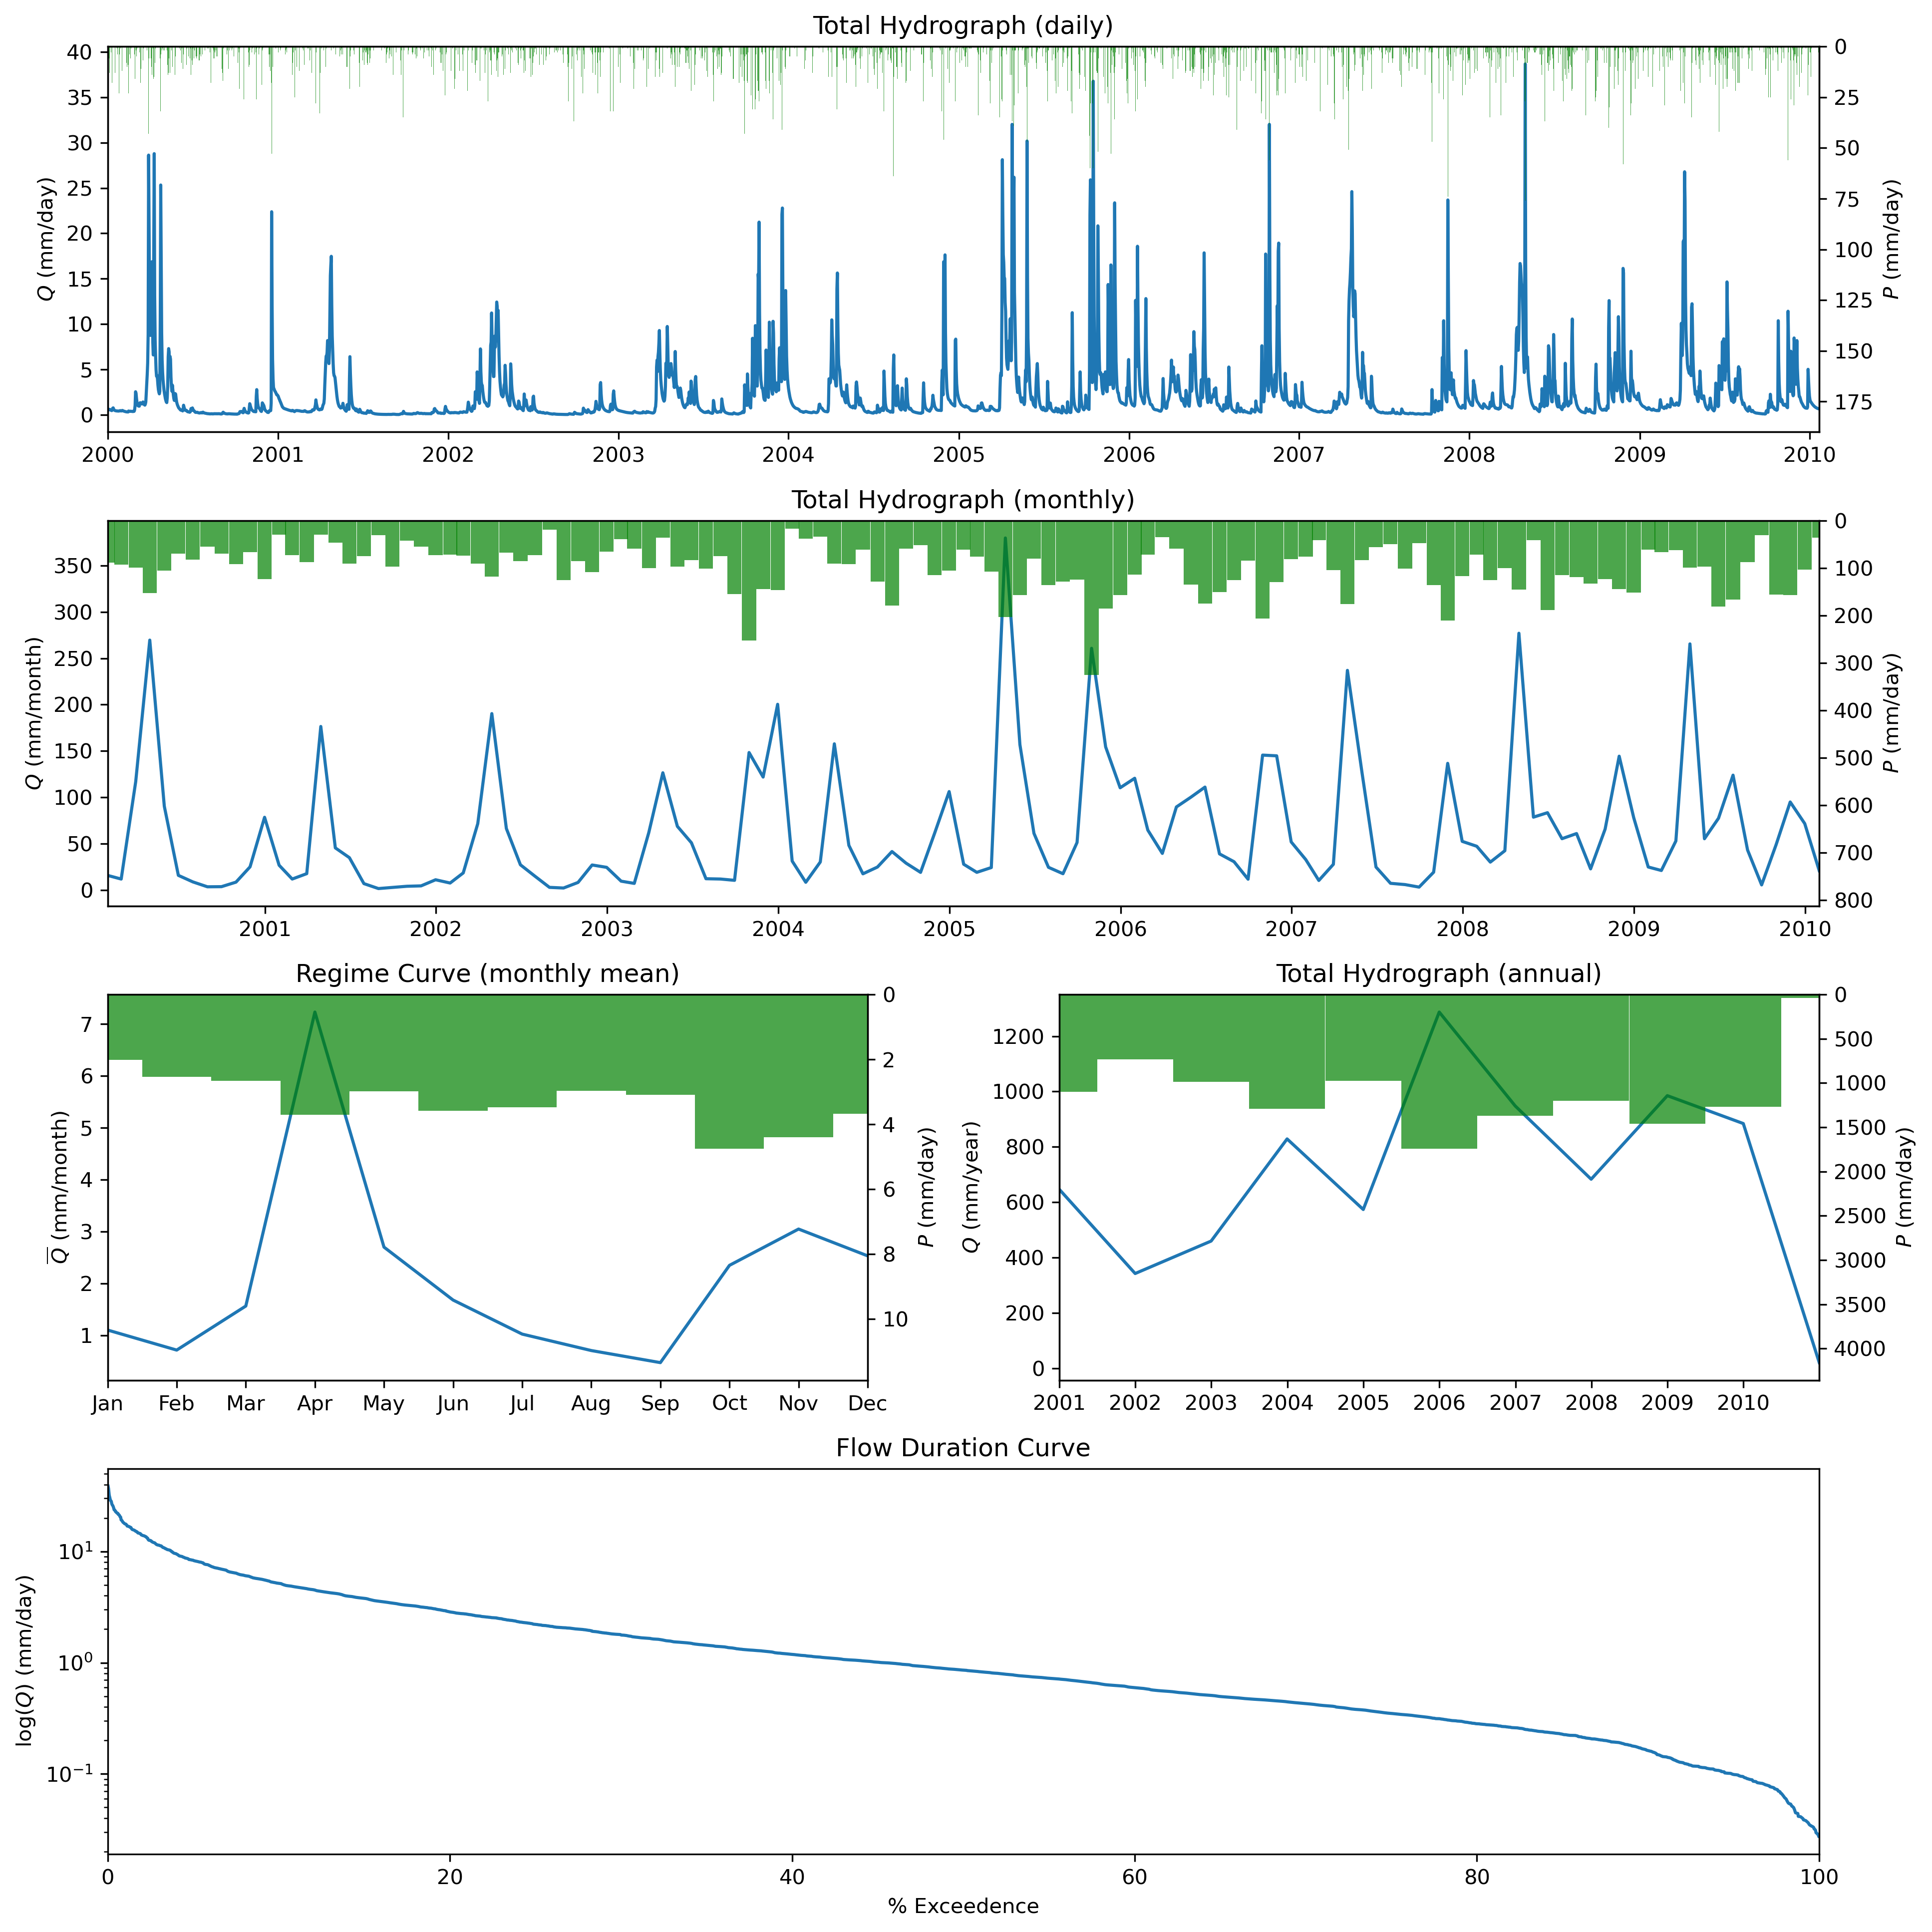

In [14]:
plot.signatures({"Q": (qobs["USGS-01031500"], wshed.drainage_area)}, clm_p["prcp (mm/day)"])

This function has also the capability to plot several discharges in one graph with proper labeling for cases where observation and simulation comparison is desired. For this kind of comparison, the input discharges should be passed as follows:
```python
{"Qobs": (qobs, wshed.drainage_area), "Qsim": (qsim, wshed.drainage_area)}
```

## Flow Accumulation

Based on topological sorting of a river network ``utils.vector_accumulation`` computes flow accumulation in the network. It returns a dataframe which is sorted from upstream to downstream and has a column named ``acc`` that shows the accumulated flow in each node. For demonstration purposes, lets assum the flow in each river segment is equal to the length of the river segment. Therefore, it should produce the same results as the ``arbolatesu`` variable in the NHDPlus database.

In [15]:
flw = utils.prepare_nhdplus(hds.NLDI.flowlines('11092450'), 0, 0, purge_non_dendritic=False)

def routing(qin, q):
    return qin + q

qsim = utils.vector_accumulation(flw[["comid", "tocomid", "lengthkm"]], routing, "lengthkm", ["lengthkm"], threading=False)
flw = flw.merge(qsim, on="comid")
diff = flw.arbolatesu - flw.acc
diff.abs().sum()

4.973799150320701e-14

It should be noted that the threading flag should be used with care. Considering the overhead of threading and the complexity of the network, parallalization might speed up the computation or slow it down. It's best to test with the flag on and off before deciding.

In [16]:
%timeit utils.vector_accumulation(flw[["comid", "tocomid", "lengthkm"]], routing, "lengthkm", ["lengthkm"], threading=False)

117 ms ± 2.05 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
%timeit utils.vector_accumulation(flw[["comid", "tocomid", "lengthkm"]], routing, "lengthkm", ["lengthkm"], threading=True)

143 ms ± 2.38 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


We can see that in this case since the network is small the serial case is slightly faster.